This notebook creates overview plots of the results from the prf fitting procedure

In [194]:
import os
import numpy as np
from matplotlib import pyplot as pl
import seaborn as sn
sn.set_style('ticks')
import nibabel as nb
from nilearn import image
%matplotlib inline

In [195]:
base_dir = '/home/shared/2018/visual/cerebellum_prf/derivatives/pp/prf'
res_fn = 'prf_results_zscore_ses2_sm3.0_tsnrw_tryout.nii.gz'

figdir = '/home/shared/2018/visual/cerebellum_prf/derivatives/figs'

In [196]:

subs = ['01']

dims = {
'x':0,
'y':1,
'ecc':2,
'ang':3,
'size':4,
'r2':5,
'amp':6
}

wang_names = {
    'V1v': 1,
    'V1d': 2,
    'V2v': 3,
    'V2d': 4,
    'V3v': 5,
    'V3d': 6,
    'hV4': 7,
    'VO1': 8,
    'VO2': 9,
    'PHC1':10,
    'PHC2': 11,
    'MST': 12,
    'hMT': 13,
    'LO2': 14,
    'LO1': 15,
    'V3b': 16,
    'V3a': 17,
    'IPS0': 18,
    'IPS1':19,
    'IPS2':20,
    'IPS3':21,
    'IPS4':22,
    'IPS5':23,
    'SLP1':24,
    'FEF':25,
}

cer_names = {
    'right_lVIIIb': 1,
    'right_mVIIIb': 2,
    'left_mVIIIb':3,
    'left_lVIIIb':4,
    'left_VIIb':5,
    'right_VIIb':6,
    'left_mOMV':7,
    'left_lOMV':8,
    'right_mOMV':9,
    'right_lOMV':10
    
}


In [197]:
these_rois = ['V1v','V1d','V2v','V2d','V3v','V3d','hV4','IPS0','all']
subplot_grid = (3,3)

cer_rois = ['left_lOMV','right_lOMV','left_mOMV','right_mOMV','left_VIIb','right_VIIb','left_mVIIIb','right_mVIIIb','left_lVIIIb','right_lVIIIb']
cer_grid = (5,2)

In [198]:
# load prf results
data = {}
for sub in subs:
    results_fn = os.path.join(base_dir,'sub-%s'%sub,'sub-%s_%s'%(sub,res_fn))
    data[sub] = nb.load(results_fn).get_data()

In [199]:
# load wang atlas
wang_dir = '/home/shared/2018/visual/cerebellum_prf/Wang_prob_retmaps'

atlas = {}
for hemi in ['lh','rh']:
    resampled_fn = os.path.join(wang_dir,'maxprob_vol_%s_resampled.nii.gz'%hemi)
    if not os.path.isfile(resampled_fn):
        in_fn = os.path.join(wang_dir,'maxprob_vol_%s.nii.gz'%hemi)
        mni_fn = os.path.join('/home','vanes','bin','fsl','data','standard','MNI152_T1_2mm_brain.nii.gz')
        ref_img = nb.load(mni_fn)        
        new_img = image.resample_to_img(nb.load(in_fn), mni_fn)
        nb.save(new_img,resampled_fn)
    atlas[hemi] = nb.load(resampled_fn).get_data()


In [200]:
# load cerebellum atlas
cer_mask_fn = '/home/vanes/git/hcp_cerebellum/resources/volume_masks/cerebellum_retmaps.nii'
cermask = nb.load(resampled_fn).get_data()

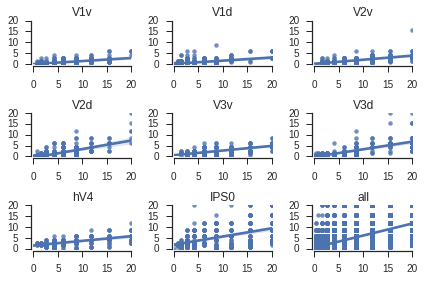

In [201]:
pl.close('all')
# create ecc-size plot for each roi
for sub in subs:
    f = pl.figure()
    for ri,roi in enumerate(these_rois):
        s = f.add_subplot(subplot_grid[0],subplot_grid[1],ri+1)
        pl.title(roi)

        if roi != 'all':
            mask = (atlas['lh'] == wang_names[roi]) + (atlas['rh'] == wang_names[roi])
        else:
            mask = np.ones_like(atlas['lh']).astype(bool)
        
        eccs = data[sub][mask][:,dims['ecc']]
        sizes = data[sub][mask][:,dims['size']]
        r2 = data[sub][mask][:,dims['r2']]
        
        r2thresh = 0.15
        
        r2mask = (r2>r2thresh)
                    
        sn.regplot(eccs[r2mask],sizes[r2mask])
        sn.despine(offset=2)
        pl.xlim(0,20)
        pl.ylim(0,20)
    pl.tight_layout()
    pl.savefig(os.path.join(figdir,'sub-%s_eccvssize.pdf'%(sub)))                

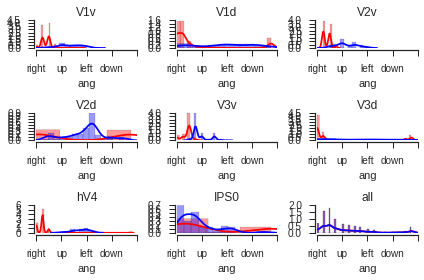

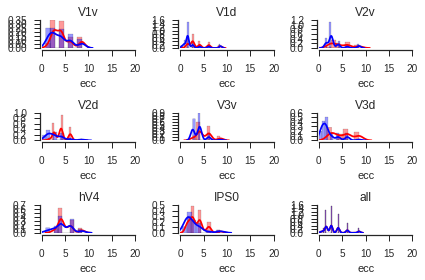

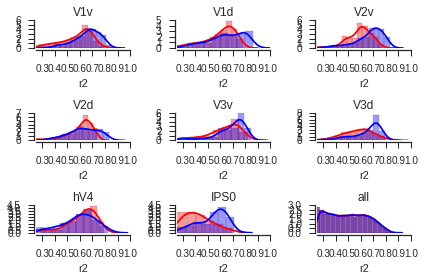

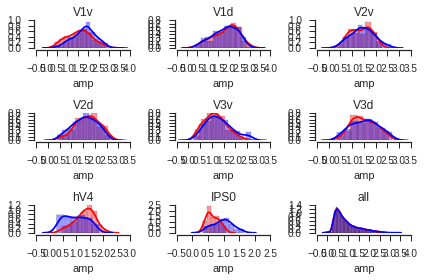

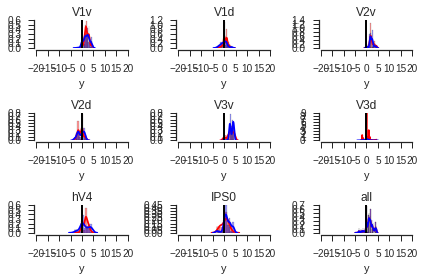

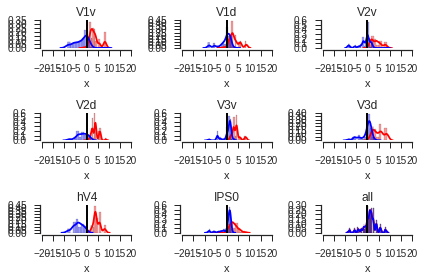

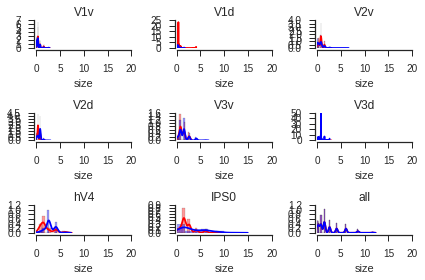

In [202]:
pl.close('all')
# create histograms
for measure in dims.keys():
    for sub in subs:
        f = pl.figure()
        for ri,roi in enumerate(these_rois):
            s = f.add_subplot(subplot_grid[0],subplot_grid[1],ri+1)
            pl.title(roi)
            for hemi in ['lh','rh']:

                if roi != 'all':
                    mask = (atlas[hemi] == wang_names[roi])
                else:
                    mask = np.ones_like(atlas[hemi]).astype(bool)

                if hemi =='lh':
                    c = 'r'
                elif hemi == 'rh':
                    c = 'b'
                
                m = data[sub][mask][:,dims[measure]]
                r2 = data[sub][mask][:,dims['r2']]
                r2thresh = 0.25
                r2mask = (r2>r2thresh)
                                
                xs_mask = np.abs(data[sub][mask][:,dims['x']]) < 10
                ys_mask = np.abs(data[sub][mask][:,dims['y']]) < 5
                size_mask = data[sub][mask][:,dims['size']] < 12
                amp_mask = data[sub][mask][:,dims['amp']] > 0
                
                mask = r2mask*amp_mask*xs_mask*ys_mask*size_mask


                pl.title(roi)
                sn.distplot(m[mask],color=c)
                pl.xlabel(measure)
                sn.despine(offset=2)
                if measure== 'ang':
                    pl.xlim(0,np.pi*2)
                    pl.xticks([0,np.pi/2,np.pi,1.5*np.pi,2*np.pi],['right','up','left','down'])
                elif measure in ['ecc','size']:
                    pl.xlim(0,20)                
                elif measure in ['x','y']:
                    pl.xlim(-20,20)
                    pl.axvline(0,color='k')
                elif measure == 'r2':
                    pl.xlim(r2thresh,1)
            pl.tight_layout()
            pl.savefig(os.path.join(figdir,'sub-%s_%s_hist.pdf'%(sub,measure)))   
            
            

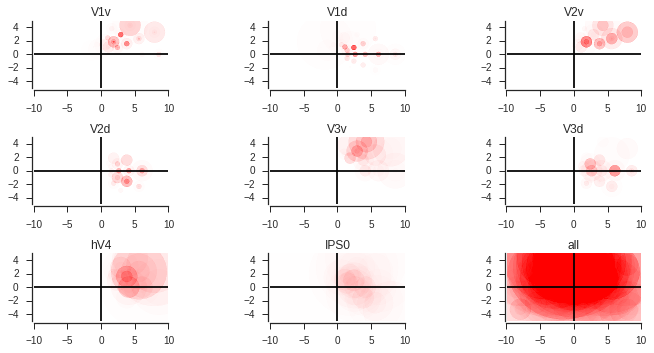

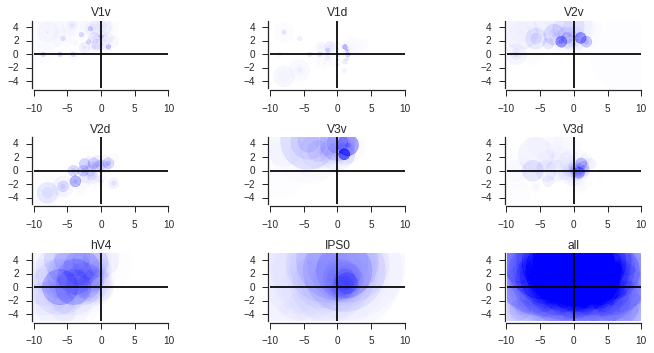

In [203]:
pl.close('all')
# create histograms
for sub in subs:
    for hemi in ['lh','rh']:

        f = pl.figure(figsize=(10,5))
        for ri,roi in enumerate(these_rois):
            s = f.add_subplot(subplot_grid[0],subplot_grid[1],ri+1,aspect='equal')
            pl.title(roi)

            if roi == 'all':
                mask = (np.random.randint(low=0,high=10,size=atlas[hemi].shape)==0)
            else:
                mask = (atlas[hemi] == wang_names[roi])

            if hemi =='lh':
                c = 'r'
            elif hemi == 'rh':
                c = 'b'
            xs = data[sub][mask][:,dims['x']]
            ys = data[sub][mask][:,dims['y']]
            sizes = data[sub][mask][:,dims['size']]

            r2s = data[sub][mask][:,dims['r2']]
            r2thresh = 0.25
            r2mask = (r2s>r2thresh)
            xs_mask = np.abs(data[sub][mask][:,dims['x']]) < 10
            ys_mask = np.abs(data[sub][mask][:,dims['y']]) < 5
            size_mask = data[sub][mask][:,dims['size']] < 12
            amp_mask = data[sub][mask][:,dims['amp']] > 0

            mask = r2mask*amp_mask*xs_mask*ys_mask*size_mask
            pl.title(roi)
            pl.axhline(0,color='k')
            pl.axvline(0,color='k')
            for x,y,size,r2 in zip(xs[mask],ys[mask],sizes[mask],r2s[mask]):
                s.add_artist(pl.Circle((x,y),size, color=c,fill=True,alpha=r2/50))
#             pl.plot(xs,ys,'o',color=c,mec='w',alpha=1)
                
            sn.despine(offset=2)
            pl.xlim(-10,10)                
            pl.ylim(-5,5)
            

        pl.tight_layout()
        pl.savefig(os.path.join(figdir,'sub-%s_scatters_%s.pdf'%(sub,hemi)))

In [ ]:
pl.close('all')
# create histograms
for sub in subs:

    f = pl.figure(figsize=(8,10))
    for ri,roi in enumerate(cer_rois):
        s = f.add_subplot(cer_grid[0],cer_grid[1],ri+1,aspect='equal')
        pl.title(roi)

        mask = (cermask == cer_names[roi])

        xs = data[sub][mask][:,dims['x']]
        ys = data[sub][mask][:,dims['y']]
        sizes = data[sub][mask][:,dims['size']]

        r2s = data[sub][mask][:,dims['r2']]
#         r2thresh = 0.3
#         r2mask = (r2>r2thresh)

        pl.title(roi)
        pl.axhline(0,color='k')
        pl.axvline(0,color='k')
        for x,y,size,r2 in zip(xs,ys,sizes,r2s):
            s.add_artist(pl.Circle((x,y),size, color=c,fill=True,alpha=r2/50))
#             pl.plot(xs,ys,'o',color=c,mec='w',alpha=1)

        sn.despine(offset=2)
        pl.xlim(-10,10)                
        pl.ylim(-5,5)


    pl.tight_layout()
    pl.savefig(os.path.join(figdir,'sub-%s_scatters_cer.pdf'%(sub)))